In [1]:
import pandas as pd

In [2]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
coords = pd.read_csv("./coords.csv", header=None)#.values
baltic_coords = np.array([[56.0000, 19.6875],
                             [58.0000, 19.6875],
                             [62.0000, 19.6875]]).T

In [4]:
coords

,0,1,2,3,4,5,6,7,8,9,...,5764,5765,5766,5767,5768,5769,5770,5771,5772,5773
0,-64.0,-64.0000,-64.000,-64.0000,-64.00,-64.0000,-64.000,-64.0000,-64.0,-64.0000,...,62.0000,62.000,62.0000,62.00,62.0000,62.000,62.0000,62.0,62.0000,62.0000
1,-180.0,-177.1875,-174.375,-171.5625,-168.75,-165.9375,-163.125,-160.3125,-157.5,-154.6875,...,-19.6875,-16.875,-14.0625,-11.25,-8.4375,-5.625,-2.8125,0.0,2.8125,19.6875


In [5]:
baltic_ids = []
for i in range(3):
    for j in range(coords.shape[1]):
        if all(coords.values[:,j] == baltic_coords[:,i]):
            baltic_ids.append(j)

In [6]:
pd.DataFrame(baltic_coords, columns=baltic_ids)

,5640,5690,5773
0,56.0000,58.0000,62.0000
1,19.6875,19.6875,19.6875


In [7]:
baltic_ids

[5640, 5690, 5773]

In [8]:
def read_test_data(start_id=-14):
    Dfs = []
    test_df = []
    coords = pd.DataFrame(baltic_coords, columns=baltic_ids)
    for name in ["mslp", "sst", "ssta", "t2m"]:
        df = pd.read_csv(f"./target/data_1940_2023/{name}_1940_2023.csv", header=None)
        Dfs.append(df)
        #Dfs.append(df.T.reset_index(drop=True))
    if start_id < -12:
        feat = pd.concat([coords, Dfs[0].iloc[start_id:start_id+12, baltic_ids], Dfs[1].iloc[start_id:start_id+12, baltic_ids], Dfs[2].iloc[start_id:start_id+12, baltic_ids], Dfs[3].iloc[start_id:start_id+12, baltic_ids]], axis=0).reset_index(drop=True)
    else:
        feat = pd.concat([coords, Dfs[0].iloc[start_id:, baltic_ids], Dfs[1].iloc[start_id:, baltic_ids], Dfs[2].iloc[start_id:, baltic_ids], Dfs[3].iloc[start_id:, baltic_ids]], axis=0).reset_index(drop=True)
    feat = feat.T.reset_index(drop=True)
    feat.columns = [f"feat_{k}" for k in range(feat.shape[1])]
    #print(feat.columns)
    return feat

In [32]:
test_data = read_test_data()

In [33]:
test_data

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49
0,56.0,19.6875,101705.445,101270.770,101208.23,101790.530,100552.04,101821.305,102291.430,101757.340,...,276.93408,276.20554,276.24722,278.44556,282.93646,288.44046,290.28903,290.97590,290.67868,284.30115
1,58.0,19.6875,101684.590,101125.410,101025.28,101587.875,100332.65,101939.160,102279.805,101790.530,...,276.21640,275.42807,275.25590,277.51584,282.17530,288.25925,290.24370,290.25458,289.77795,283.07422
2,62.0,19.6875,101750.400,100919.914,100670.17,101230.780,100172.53,102125.650,102016.590,101739.336,...,274.09964,273.67374,272.60630,275.19790,279.21760,285.83618,289.50974,289.69458,287.90945,279.48944


In [11]:
monthly_stats = np.load("monthly_stats.npy")

In [12]:
monthly_stats[baltic_ids].shape

(3, 24)

In [13]:
monthly_stats_df = pd.DataFrame(monthly_stats[baltic_ids], columns=[f"add_feat_{i}" for i in range(24)])

In [14]:
#data_rich = pd.concat([test_data.reset_index(drop=True), monthly_stats_df], axis=1)

In [15]:
import joblib

## K-Fold Predictions

In [16]:
import os
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler

In [17]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators, coeffs):
        super().__init__()
        self.estimators = estimators
        self.coeffs = coeffs
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [coeff*estimator.predict(X) for estimator, coeff in zip(self.estimators, self.coeffs)]
        return np.sum(y_preds, axis=0)

In [18]:
def load_boosting_models(path, num_folds=5):
    Models = []
    for fold in range(num_folds):
        for model_name in ["catb", "lgb"]:
            for trained_model_path in os.listdir(path):
                if trained_model_path.startswith("."): continue
                if model_name in trained_model_path and f'fold{fold}' in trained_model_path:
                    model = joblib.load(f'{path}/{trained_model_path}')
                    Models.append(model)
    return Models

In [19]:
def load_xgb_models(path, num_folds=5):
    Models = []
    for fold in range(num_folds):
        for model_name in ["xgb"]:
            for trained_model_path in os.listdir(path):
                if trained_model_path.startswith("."): continue
                if model_name in trained_model_path and f'fold{fold}' in trained_model_path:
                    model = joblib.load(f'{path}/{trained_model_path}')
                    Models.append(model)
    return Models

In [20]:
boosting_models = load_boosting_models("./kfold_trained2/", 5)
coeffs = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
boosting_models = VotingModel(boosting_models, coeffs)

In [21]:
add_feat_boosting_models = VotingModel(load_boosting_models("./trained3/"), coeffs)

In [22]:
from pytorch_implementation.dataset import Dataset
from pytorch_implementation.helper_funcs import *

In [23]:
trained_nn_models = load_trained("./trained_nn2")

In [24]:
def predict_september2024():
    def predict3monthsahead(input_data, data_rich):
        y_pred_boost = boosting_models.predict(input_data.values)
        y_pred_add_feat = add_feat_boosting_models.predict(data_rich.values)
        y_pred_gru = average_prediction(data_rich.values, trained_nn_models[0::2])
        y_pred_lstm = average_prediction(data_rich.values, trained_nn_models[1::2])
        y_pred = 0.29*y_pred_add_feat + 0.925*(0.92*y_pred_boost + 0.01*y_pred_gru.squeeze() + 0.10*y_pred_lstm.squeeze())
        return y_pred
    ## First predict for Jan, Feb, March 2024    
    jan_feb_march = []
    print('Predicting for Jan, Feb, March 2024...')
    for start_id in [-14, -13, -12]:
        input_data = read_test_data(start_id)
        data_rich = pd.concat([input_data.reset_index(drop=True), monthly_stats_df], axis=1)
        y_pred = predict3monthsahead(input_data, data_rich)
        jan_feb_march.append(y_pred)
    
    jan_feb_march = np.stack(jan_feb_march, axis=1)
    
    ## Now use the predicted values jan_feb_march together with data from Feb 2023 onwards to predict for April, May, June 2024
    ## Note that only SSTA values will change, we keep the other variables unchanged as we do not predict new values for those
    apr_may_jun = []
    print('Predicting for April, May, June 2024...')
    for i in range(3):
        print('Before adding predicted data: ', input_data.iloc[:,35])
        ## SSTA features are from column 24 till 36
        input_data.loc[:, [f"feat_{k}" for k in range(24,36)]] = np.concatenate([input_data.iloc[:, 25:36].values, jan_feb_march[:,i].reshape(-1,1)], axis=1)
        print('After adding predicted data: ', input_data.iloc[:,35])
        data_rich = pd.concat([input_data.reset_index(drop=True), monthly_stats_df], axis=1)
        y_pred = predict3monthsahead(input_data, data_rich)
        apr_may_jun.append(y_pred)
    apr_may_jun = np.stack(apr_may_jun, axis=1)
    
    print('Final prediction (September 2024)...')
    ## Finally, we predict for September 2024 using data up to Jun 2024 (remember we predicted ssta from Jan 2024 to June 2024)
    input_data.loc[:, [f"feat_{k}" for k in range(24,36)]] = np.concatenate([input_data.iloc[:, 27:36].values, apr_may_jun], axis=1)
    data_rich = pd.concat([input_data.reset_index(drop=True), monthly_stats_df], axis=1)
    pred_sept = predict3monthsahead(input_data, data_rich)
    
    return jan_feb_march, apr_may_jun, pred_sept

In [25]:
jan_feb_march, apr_may_jun, pred_sept = predict_september2024()

Predicting for Jan, Feb, March 2024...
Predicting for April, May, June 2024...
Before adding predicted data:  0    1.186523
1    1.514099
2    1.142975
Name: feat_35, dtype: float64
After adding predicted data:  0    0.870196
1    0.787588
2    0.443585
Name: feat_35, dtype: float64
Before adding predicted data:  0    0.870196
1    0.787588
2    0.443585
Name: feat_35, dtype: float64
After adding predicted data:  0    0.862272
1    0.823358
2    0.170854
Name: feat_35, dtype: float64
Before adding predicted data:  0    0.862272
1    0.823358
2    0.170854
Name: feat_35, dtype: float64
After adding predicted data:  0    0.736040
1    0.470608
2   -0.262733
Name: feat_35, dtype: float64
Final prediction (September 2024)...


In [26]:
pred_sept

array([ 0.71619916,  0.45978862, -0.21562257])

In [27]:
all_preds = np.concatenate([jan_feb_march, apr_may_jun, pred_sept.reshape(-1,1)], axis=1)

In [28]:
import matplotlib.pyplot as plt

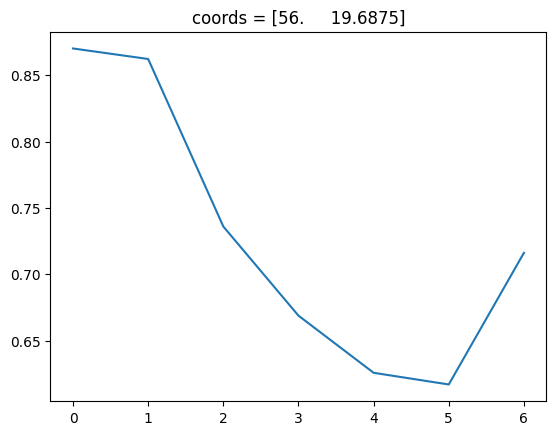

In [29]:
plt.plot(all_preds[0,:])
plt.title(f'coords = {baltic_coords.T[0]}')
plt.show()

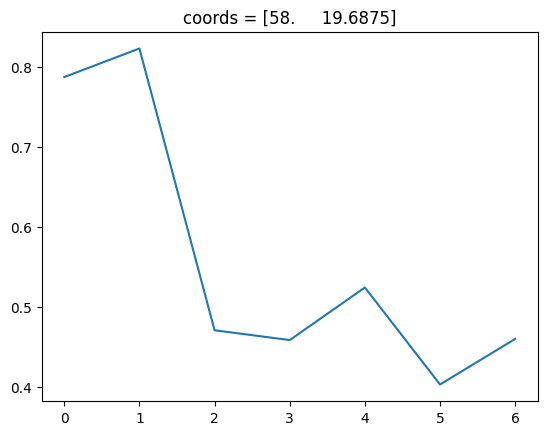

In [30]:
plt.plot(all_preds[1,:])
plt.title(f'coords = {baltic_coords.T[1]}')
plt.show()

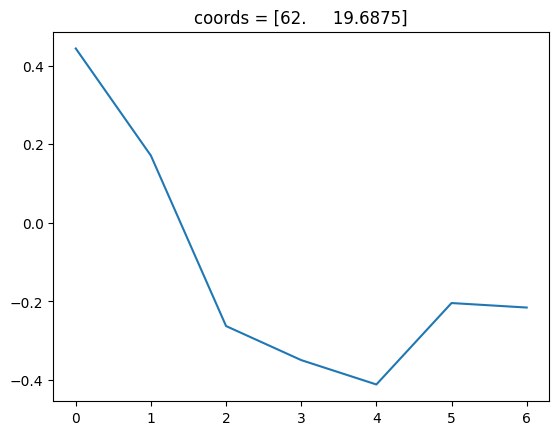

In [31]:
plt.plot(all_preds[2,:])
plt.title(f'coords = {baltic_coords.T[2]}')
plt.show()